In [680]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter, OrderedDict
import operator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier,Pool
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K
from keras import regularizers
from keras.optimizers import Adam

In [3]:
train_df = pd.read_json('train.json')
test_df = pd.read_json('test.json')

In [5]:
print(train_df.shape, test_df.shape)

(39774, 3) (9944, 2)


In [12]:
train_id = train_df['id'].values
test_id = test_df['id'].values

In [16]:
print(f'There is {len(set(train_id).intersection(set(test_id)))} intersection between train and test sets.')

There is 0 intersection between train and test sets.


In [19]:
train_df.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

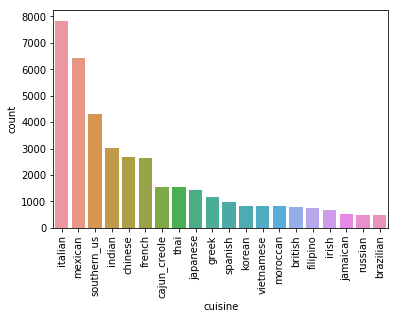

In [27]:
#how many cuisines and their occurance in train_df?
sns.countplot('cuisine',data=train_df,order=train_df['cuisine'].value_counts().index)
plt.xticks(rotation=90)

In [31]:
#how many different ingredients and their occurance in train_df?
train_ingredients = []
for index, row in train_df.iterrows():
    ingredients = row['ingredients']
    train_ingredients.extend(ingredients)

In [55]:
ingredients_dict = Counter(train_ingredients)
#plot only top 10 most popular ingredients
sorted_ingredients = sorted(ingredients_dict.items(), key=operator.itemgetter(1), reverse=True)
top10_sorted_ingredients = sorted_ingredients[:10]
top10_ingredients_dict = OrderedDict()
for ingredient, count in top10_sorted_ingredients:
    top10_ingredients_dict[ingredient]=count

In [56]:
top10_ingredients_dict

OrderedDict([('salt', 18049),
             ('onions', 7972),
             ('olive oil', 7972),
             ('water', 7457),
             ('garlic', 7380),
             ('sugar', 6434),
             ('garlic cloves', 6237),
             ('butter', 4848),
             ('ground black pepper', 4785),
             ('all-purpose flour', 4632)])

Text(0.5,1,'top 10 most popular ingredients')

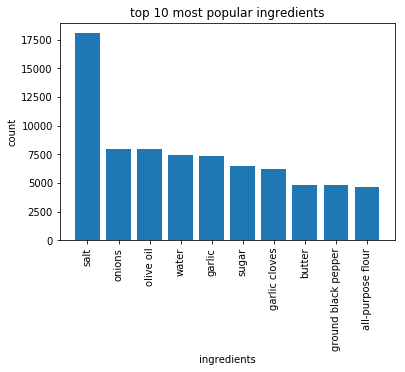

In [62]:
plt.bar(top10_ingredients_dict.keys(),top10_ingredients_dict.values())
plt.xticks(rotation=90)
plt.xlabel('ingredients')
plt.ylabel('count')
plt.title('top 10 most popular ingredients')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 43 Text xticklabel objects>)

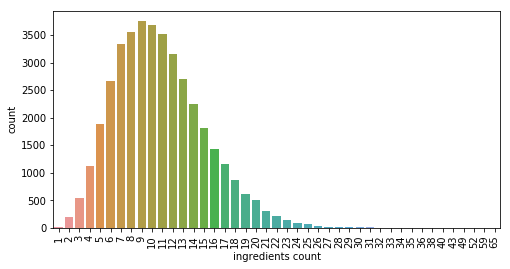

In [68]:
#On average, how many ingredients each dish may have?
train_df['ingredients count'] = train_df['ingredients'].apply(lambda x:len(x))
plt.figure(figsize=(8,4))
sns.countplot(train_df['ingredients count'])
plt.xticks(rotation=90)

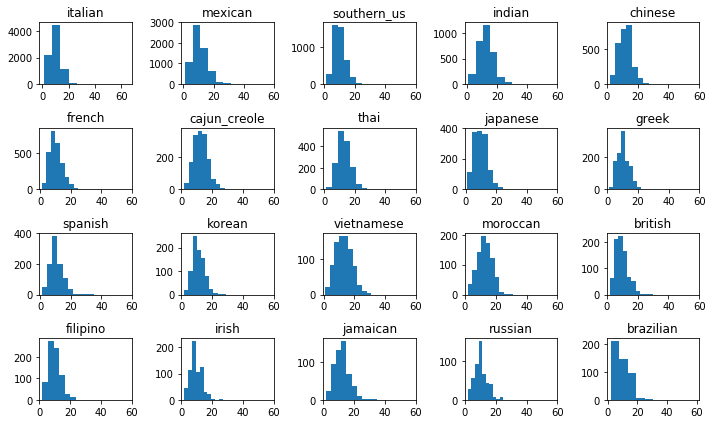

In [85]:
plt.figure(figsize=(10,6))
for index, cuisine in enumerate(train_df['cuisine'].value_counts().index):
    plt.subplot(4,5,index+1)
    plt.hist(train_df[train_df['cuisine']==cuisine]['ingredients count'])
    plt.title(cuisine)
    plt.xticks([0,20,40,60])
    plt.tight_layout()

In [86]:
def top10_ingredients_cuisine(cuisine):
    cuisine_ingredients = []
    for index, row in train_df.iterrows():
        if row['cuisine']==cuisine:      
            cuisine_ingredients.extend(row['ingredients'])
    ingredients_dict = Counter(cuisine_ingredients)
    sorted_ingredients = sorted(ingredients_dict.items(), key=operator.itemgetter(1), reverse=True)
    top10_sorted_ingredients = sorted_ingredients[:10]
    top10_ingredients_dict = OrderedDict()
    for ingredient, count in top10_sorted_ingredients:
        top10_ingredients_dict[ingredient]=count
    return top10_ingredients_dict

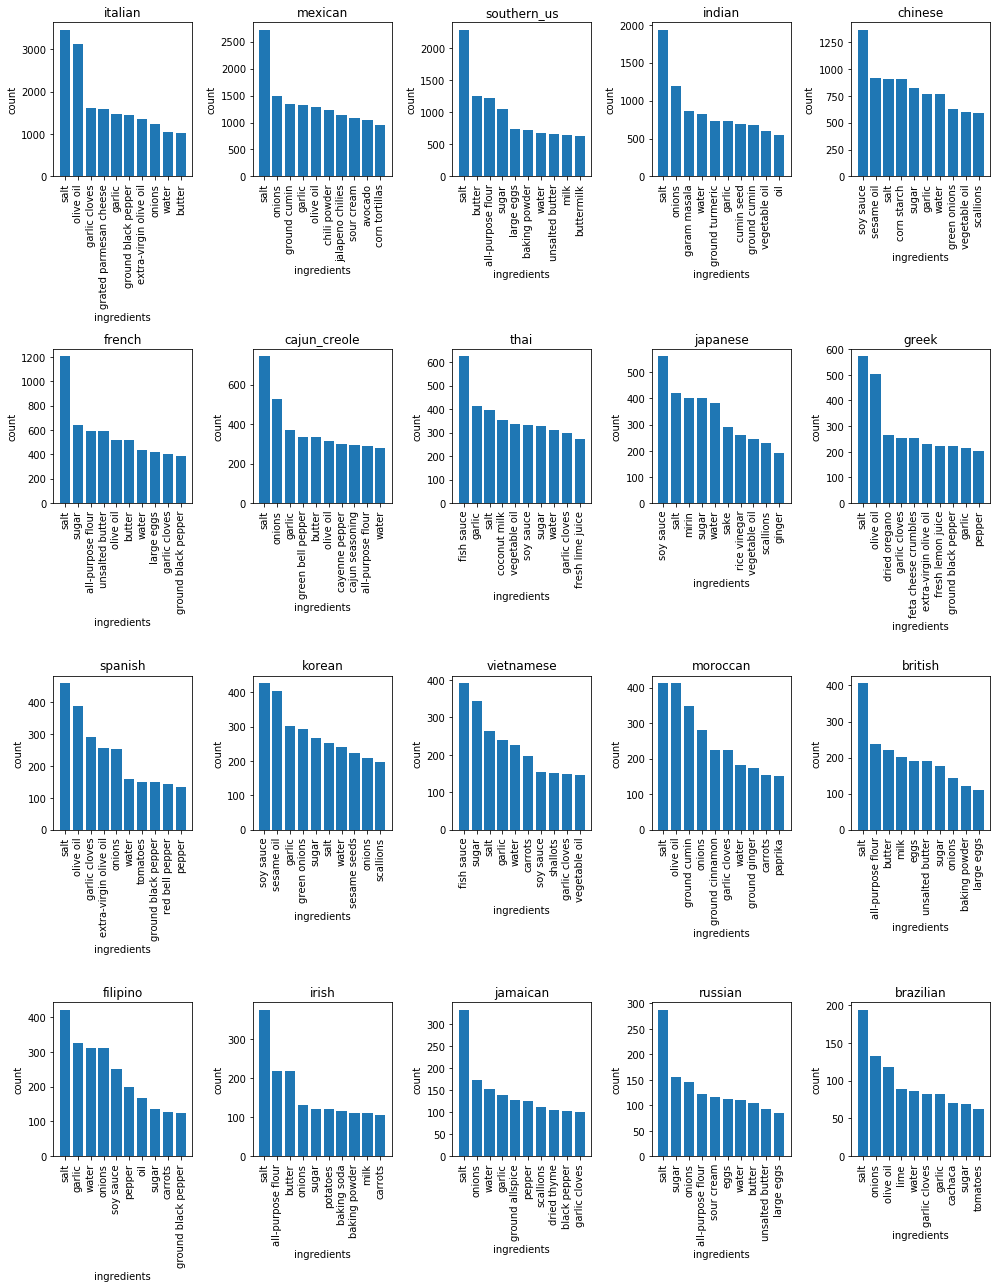

In [96]:
plt.figure(figsize=(14,18))
for index, cuisine in enumerate(train_df['cuisine'].value_counts().index):
    plt.subplot(4,5,index+1)
    top10_ingredients_dict = top10_ingredients_cuisine(cuisine)
    plt.bar(top10_ingredients_dict.keys(),top10_ingredients_dict.values())
    plt.xticks(rotation=90)
    plt.xlabel('ingredients')
    plt.ylabel('count')
    plt.title(cuisine)
    plt.tight_layout()

In [139]:
def connect_word(word):
    if len(word.split())>1:
        if '-' in word:
            word=re.sub('-',' ',word)
            return '_'.join(word.split())
        return '_'.join(word.split())
    return word

In [132]:
top10_ingredients_per_cuisine = OrderedDict()
for cuisine in set(train_df['cuisine']):
    top10_ingredients_per_cuisine[cuisine] = top10_ingredients_cuisine(cuisine).keys()

In [169]:
text = []
for cuisine, ingredients in top10_ingredients_per_cuisine.items():
    ingredients = list(ingredients)
    new_version_ingredients = [connect_word(ingredient) for ingredient in ingredients]
    text.append(' '.join(new_version_ingredients))

In [170]:
text

['salt garlic water onions soy_sauce pepper oil sugar carrots ground_black_pepper',
 'salt butter all_purpose_flour sugar large_eggs baking_powder water unsalted_butter milk buttermilk',
 'salt olive_oil garlic_cloves extra_virgin_olive_oil onions water tomatoes ground_black_pepper red_bell_pepper pepper',
 'salt onions garlic green_bell_pepper butter olive_oil cayenne_pepper cajun_seasoning all_purpose_flour water',
 'salt onions garam_masala water ground_turmeric garlic cumin_seed ground_cumin vegetable_oil oil',
 'soy_sauce sesame_oil salt corn_starch sugar garlic water green_onions vegetable_oil scallions',
 'salt all_purpose_flour butter milk eggs unsalted_butter sugar onions baking_powder large_eggs',
 'salt olive_oil garlic_cloves grated_parmesan_cheese garlic ground_black_pepper extra_virgin_olive_oil onions water butter',
 'salt sugar all_purpose_flour unsalted_butter olive_oil butter water large_eggs garlic_cloves ground_black_pepper',
 'salt olive_oil ground_cumin onions gro

In [173]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(text)
print(vectorizer.get_feature_names())

['all_purpose_flour', 'avocado', 'baking_powder', 'baking_soda', 'black_pepper', 'butter', 'buttermilk', 'cachaca', 'cajun_seasoning', 'carrots', 'cayenne_pepper', 'chili_powder', 'coconut_milk', 'corn_starch', 'corn_tortillas', 'cumin_seed', 'dried_oregano', 'dried_thyme', 'eggs', 'extra_virgin_olive_oil', 'feta_cheese_crumbles', 'fish_sauce', 'fresh_lemon_juice', 'fresh_lime_juice', 'garam_masala', 'garlic', 'garlic_cloves', 'ginger', 'grated_parmesan_cheese', 'green_bell_pepper', 'green_onions', 'ground_allspice', 'ground_black_pepper', 'ground_cinnamon', 'ground_cumin', 'ground_ginger', 'ground_turmeric', 'jalapeno_chilies', 'large_eggs', 'lime', 'milk', 'mirin', 'oil', 'olive_oil', 'onions', 'paprika', 'pepper', 'potatoes', 'red_bell_pepper', 'rice_vinegar', 'sake', 'salt', 'scallions', 'sesame_oil', 'sesame_seeds', 'shallots', 'sour_cream', 'soy_sauce', 'sugar', 'tomatoes', 'unsalted_butter', 'vegetable_oil', 'water']


In [176]:
text_tokenized = X.toarray()

In [178]:
text_tokenized

array([[0, 0, 0, ..., 0, 0, 1],
       [1, 0, 1, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

In [177]:
text_tokenized.shape

(20, 63)

In [180]:
text_embedded = TSNE(n_components=2).fit_transform(text_tokenized)

In [181]:
text_embedded.shape

(20, 2)

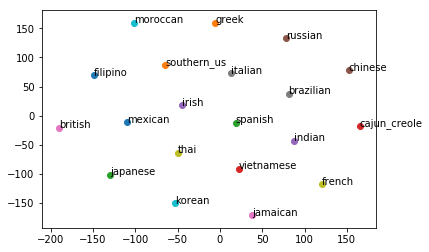

In [184]:
for i, cuisine in enumerate(top10_ingredients_per_cuisine.keys()):
    plt.scatter(text_embedded[i,0],text_embedded[i,1])
    plt.text(text_embedded[i,0],text_embedded[i,1],cuisine)

In [232]:
#modeling starts here
train_df = pd.read_json('train.json')

In [233]:
train_df.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [234]:
def clean_ingredients_list(ingredients_list):
    clean_list = []
    for ingredient in ingredients_list:
        if len(ingredient.split())>1: # ingredient has more than 1 word
            if '-' in ingredient: # dash - in between
                ingredient=re.sub('-','_',ingredient)
                clean_list.append(ingredient)
            elif ',' in ingredient: # human error when , in between two gredients
                ingredients=ingredient.split(', ')
                for split_ingredient in ingredients:
                    clean_list.append(re.sub(' ','_',split_ingredient))
            else:
                clean_list.append(re.sub(' ','_',ingredient))
        else:
            clean_list.append(ingredient)
    return clean_list

In [235]:
train_df['clean_ingredients'] = train_df['ingredients'].apply(clean_ingredients_list)

In [236]:
train_df.head()

,cuisine,id,ingredients,clean_ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...","[romaine_lettuce, black_olives, grape_tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...","[plain_flour, ground_pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...","[eggs, pepper, salt, mayonaise, cooking_oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]","[water, vegetable_oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...","[black_pepper, shallots, cornflour, cayenne_pe..."


In [237]:
full_text = []
for index, row in train_df.iterrows():
    clean_ingredients_string = ' '.join(row['clean_ingredients'])
    full_text.append(clean_ingredients_string)

In [239]:
v = CountVectorizer()
x = v.fit_transform(full_text)

In [259]:
len(v.get_feature_names())

6807

In [ ]:
# 1. The possible number of ingredients (features) is too large. Since most of the dishes would 
# only have 10 ingredients, the feature vectors would be too sparse if count every single ingredient

# 2. The ingredients list contains errors such as numbers, incorrectly placed ,

In [545]:
train_ingredients = []
for index, row in train_df.iterrows():
    ingredients = row['ingredients']
    train_ingredients.extend(ingredients)
    
ingredients_dict = Counter(train_ingredients)
sorted_ingredients = sorted(ingredients_dict.items(), key=operator.itemgetter(1), reverse=True)
top300_sorted_ingredients = sorted_ingredients[:300]
top300_ingredients_dict = OrderedDict()
for ingredient, count in top300_sorted_ingredients:
    top300_ingredients_dict[ingredient]=count

In [546]:
top300_ingredients_dict

OrderedDict([('salt', 18049),
             ('onions', 7972),
             ('olive oil', 7972),
             ('water', 7457),
             ('garlic', 7380),
             ('sugar', 6434),
             ('garlic cloves', 6237),
             ('butter', 4848),
             ('ground black pepper', 4785),
             ('all-purpose flour', 4632),
             ('pepper', 4438),
             ('vegetable oil', 4385),
             ('eggs', 3388),
             ('soy sauce', 3296),
             ('kosher salt', 3113),
             ('green onions', 3078),
             ('tomatoes', 3058),
             ('large eggs', 2948),
             ('carrots', 2814),
             ('unsalted butter', 2782),
             ('ground cumin', 2747),
             ('extra-virgin olive oil', 2747),
             ('black pepper', 2627),
             ('milk', 2263),
             ('chili powder', 2036),
             ('oil', 1970),
             ('red bell pepper', 1939),
             ('purple onion', 1896),
             ('scallio

In [547]:
def ingredients_filter(ingredients_list):
    filtered_ingredients_list = []
    for ingredient in ingredients_list:
        if ingredient in top300_ingredients_dict.keys():
            filtered_ingredients_list.append(ingredient)
    return filtered_ingredients_list

In [548]:
train_df['filtered_ingredients'] = train_df['ingredients'].apply(ingredients_filter)

In [549]:
full_text = []
for i, row in train_df.iterrows():
    ingredients = row['filtered_ingredients']
    ingredients_revised = []
    for ingredient in ingredients:
        if len(ingredient.split())>1:
            if '-' in ingredient:
                ingredient = re.sub('-','_',ingredient)
                ingredient = re.sub(' ','_',ingredient)
                ingredients_revised.append(ingredient)
            elif '&' in ingredient:
                ingredient = re.sub('&','and',ingredient)
                ingredient = re.sub(' ','_',ingredient)
                ingredients_revised.append(ingredient)
            else:
                ingredient = re.sub(' ','_',ingredient)
                ingredients_revised.append(ingredient)
        else:
            ingredients_revised.append(ingredient)
    full_text.append(' '.join(ingredients_revised))

In [550]:
v = CountVectorizer()
x = v.fit_transform(full_text)

In [551]:
len(v.get_feature_names()) # This matches the top 300 ingredients choice

300

In [552]:
index_ingredient = {i:word for i,word in enumerate(v.get_feature_names())}

In [553]:
index_ingredient

{0: 'active_dry_yeast',
 1: 'all_purpose_flour',
 2: 'arborio_rice',
 3: 'avocado',
 4: 'bacon',
 5: 'baguette',
 6: 'baking_powder',
 7: 'baking_soda',
 8: 'balsamic_vinegar',
 9: 'basil',
 10: 'basmati_rice',
 11: 'bay_leaf',
 12: 'bay_leaves',
 13: 'beansprouts',
 14: 'beef',
 15: 'beef_broth',
 16: 'bell_pepper',
 17: 'black_beans',
 18: 'black_pepper',
 19: 'black_peppercorns',
 20: 'boiling_water',
 21: 'boneless_chicken_skinless_thigh',
 22: 'boneless_skinless_chicken_breast_halves',
 23: 'boneless_skinless_chicken_breasts',
 24: 'bread_crumbs',
 25: 'brown_sugar',
 26: 'butter',
 27: 'buttermilk',
 28: 'cabbage',
 29: 'cajun_seasoning',
 30: 'canola_oil',
 31: 'capers',
 32: 'carrots',
 33: 'cayenne',
 34: 'cayenne_pepper',
 35: 'celery',
 36: 'celery_ribs',
 37: 'cheddar_cheese',
 38: 'cheese',
 39: 'cherry_tomatoes',
 40: 'chicken',
 41: 'chicken_breasts',
 42: 'chicken_broth',
 43: 'chicken_stock',
 44: 'chicken_thighs',
 45: 'chickpeas',
 46: 'chile_pepper',
 47: 'chiles',


In [554]:
train = x.toarray()

In [696]:
train.shape 

(39774, 300)

In [556]:
empty_array = 0
for i in range(train.shape[0]):
    if not any(train[i]): # all 0s
        empty_array+=1
print('Out of {} training sample, {:04.2f}% of them are empey (all 0s)'.format(train.shape[0],
                                                                100*empty_array/train.shape[0]))

Out of 39774 training sample, 0.65% of them are empey (all 0s)


In [557]:
le = LabelEncoder()
label_encoded_target = le.fit_transform(train_df['cuisine'])

In [558]:
X_train,X_test,y_train,y_test = train_test_split(train,label_encoded_target,
                                                test_size=0.2,stratify=label_encoded_target,
                                                random_state=101)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31819, 300) (7955, 300) (31819,) (7955,)


In [561]:
knn_clf = KNeighborsClassifier(n_neighbors=20)
knn_clf.fit(X_train,y_train)
print(f'training score: {accuracy_score(y_train,knn_clf.predict(X_train))}')
print(f'test score: {accuracy_score(y_test,knn_clf.predict(X_test))}')

training score: 0.5496715798736604
test score: 0.4910119421747329


In [510]:
#XGB

model = XGBClassifier(n_estimators=10000,learning_rate=0.1,objective='multi:softmax',num_class=20)
eval_set = [(X_train, y_train),(X_test, y_test)]
model.fit(X_train, y_train, 
          early_stopping_rounds=30,
          eval_metric="merror", 
          eval_set=eval_set, 
          verbose=True)

[0]	validation_0-merror:0.524089	validation_1-merror:0.525079
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.492064	validation_1-merror:0.496543
[2]	validation_0-merror:0.479713	validation_1-merror:0.485732
[3]	validation_0-merror:0.471919	validation_1-merror:0.479698
[4]	validation_0-merror:0.462334	validation_1-merror:0.47115
[5]	validation_0-merror:0.456237	validation_1-merror:0.465242
[6]	validation_0-merror:0.455703	validation_1-merror:0.466373
[7]	validation_0-merror:0.455545	validation_1-merror:0.467882
[8]	validation_0-merror:0.450046	validation_1-merror:0.464613
[9]	validation_0-merror:0.445426	validation_1-merror:0.459837
[10]	validation_0-merror:0.444294	validation_1-merror:0.458957
[11]	validation_0-merror:0.444577	validation_1-merror:0.460088
[12]	validation_0-merror:0.443446	validation_1-merror:0.459837
[13]	validation_0-merror:0.44

[128]	validation_0-merror:0.346523	validation_1-merror:0.377876
[129]	validation_0-merror:0.34602	validation_1-merror:0.377373
[130]	validation_0-merror:0.345485	validation_1-merror:0.377373
[131]	validation_0-merror:0.345328	validation_1-merror:0.376996
[132]	validation_0-merror:0.344825	validation_1-merror:0.377121
[133]	validation_0-merror:0.344543	validation_1-merror:0.376996
[134]	validation_0-merror:0.34426	validation_1-merror:0.376493
[135]	validation_0-merror:0.344008	validation_1-merror:0.376367
[136]	validation_0-merror:0.344291	validation_1-merror:0.376996
[137]	validation_0-merror:0.343725	validation_1-merror:0.376996
[138]	validation_0-merror:0.343443	validation_1-merror:0.377247
[139]	validation_0-merror:0.342845	validation_1-merror:0.376493
[140]	validation_0-merror:0.342688	validation_1-merror:0.376367
[141]	validation_0-merror:0.342374	validation_1-merror:0.375864
[142]	validation_0-merror:0.342185	validation_1-merror:0.375236
[143]	validation_0-merror:0.341871	validat

[257]	validation_0-merror:0.312989	validation_1-merror:0.359145
[258]	validation_0-merror:0.312863	validation_1-merror:0.358894
[259]	validation_0-merror:0.312643	validation_1-merror:0.358642
[260]	validation_0-merror:0.312612	validation_1-merror:0.358517
[261]	validation_0-merror:0.312235	validation_1-merror:0.358391
[262]	validation_0-merror:0.312172	validation_1-merror:0.358642
[263]	validation_0-merror:0.312203	validation_1-merror:0.358517
[264]	validation_0-merror:0.312203	validation_1-merror:0.358517
[265]	validation_0-merror:0.311826	validation_1-merror:0.358265
[266]	validation_0-merror:0.311638	validation_1-merror:0.358014
[267]	validation_0-merror:0.311543	validation_1-merror:0.357637
[268]	validation_0-merror:0.311229	validation_1-merror:0.35726
[269]	validation_0-merror:0.311323	validation_1-merror:0.35726
[270]	validation_0-merror:0.310821	validation_1-merror:0.357008
[271]	validation_0-merror:0.310632	validation_1-merror:0.35726
[272]	validation_0-merror:0.310506	validati

[386]	validation_0-merror:0.293787	validation_1-merror:0.346574
[387]	validation_0-merror:0.293535	validation_1-merror:0.346449
[388]	validation_0-merror:0.293504	validation_1-merror:0.346826
[389]	validation_0-merror:0.293378	validation_1-merror:0.346574
[390]	validation_0-merror:0.293378	validation_1-merror:0.346574
[391]	validation_0-merror:0.293252	validation_1-merror:0.346574
[392]	validation_0-merror:0.293127	validation_1-merror:0.346323
[393]	validation_0-merror:0.293064	validation_1-merror:0.345946
[394]	validation_0-merror:0.29319	validation_1-merror:0.346197
[395]	validation_0-merror:0.293001	validation_1-merror:0.346323
[396]	validation_0-merror:0.292907	validation_1-merror:0.346574
[397]	validation_0-merror:0.29275	validation_1-merror:0.3467
[398]	validation_0-merror:0.292592	validation_1-merror:0.346574
[399]	validation_0-merror:0.292561	validation_1-merror:0.346323
[400]	validation_0-merror:0.292435	validation_1-merror:0.346072
[401]	validation_0-merror:0.292372	validatio

[515]	validation_0-merror:0.280776	validation_1-merror:0.340918
[516]	validation_0-merror:0.280713	validation_1-merror:0.340541
[517]	validation_0-merror:0.280493	validation_1-merror:0.340666
[518]	validation_0-merror:0.280336	validation_1-merror:0.340792
[519]	validation_0-merror:0.280399	validation_1-merror:0.340792
[520]	validation_0-merror:0.28021	validation_1-merror:0.340918
[521]	validation_0-merror:0.280179	validation_1-merror:0.340918
[522]	validation_0-merror:0.280084	validation_1-merror:0.341043
[523]	validation_0-merror:0.280116	validation_1-merror:0.341043
[524]	validation_0-merror:0.280147	validation_1-merror:0.340918
[525]	validation_0-merror:0.279833	validation_1-merror:0.340415
[526]	validation_0-merror:0.279864	validation_1-merror:0.340666
[527]	validation_0-merror:0.279676	validation_1-merror:0.340415
Stopping. Best iteration:
[507]	validation_0-merror:0.281593	validation_1-merror:0.339912



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=10000,
       n_jobs=1, nthread=None, num_class=30, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [511]:
# 100 features got 0.445 test merror
# 200 features got 0.374 test merror
# 300 features got 0.340 test merror

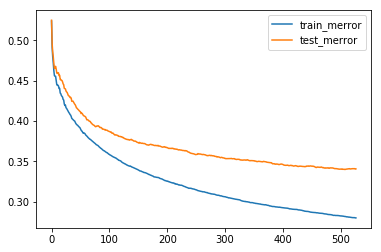

In [516]:
results = model.evals_result()
plt.plot(results['validation_0']['merror'],label='train_merror')
plt.plot(results['validation_1']['merror'],label='test_merror')
plt.legend()

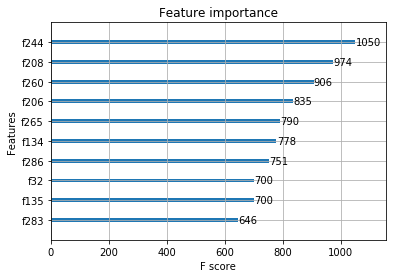

In [522]:
plot_importance(model,max_num_features=10)

In [526]:
for index in [244,208,260,206,265,134,286,32,135,286]:
    print(index_ingredient[index])

salt
onions
soy_sauce
olive_oil
sugar
garlic
water
carrots
garlic_cloves
water


In [581]:
# Let's try the tfidf vecterization method
train_df = pd.read_json('train.json')
train_df.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [582]:
train_df['seperated_ingredients'] = train_df['ingredients'].apply(','.join)

In [583]:
vect = TfidfVectorizer(binary=True).fit(train_df['seperated_ingredients'].values)
X_train_vectorized = vect.transform(train_df['seperated_ingredients'].values)

In [584]:
X_train_vectorized.shape

(39774, 3051)

In [585]:
encoder = LabelEncoder()
y_transformed = encoder.fit_transform(train_df['cuisine'])

In [586]:
X_train, X_test, y_train, y_test = train_test_split(X_train_vectorized, y_transformed,
                                                    test_size=0.2,
                                                    random_state = 0)

In [587]:
X_train.shape

(31819, 3051)

In [588]:
model = XGBClassifier(n_estimators=10000,learning_rate=0.1,objective='multi:softmax',num_class=20)
eval_set = [(X_train, y_train),(X_test, y_test)]
model.fit(X_train, y_train, 
          early_stopping_rounds=20,
          eval_metric="merror", 
          eval_set=eval_set, 
          verbose=True)

[0]	validation_0-merror:0.468054	validation_1-merror:0.456694
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.407178	validation_1-merror:0.409554
[2]	validation_0-merror:0.39511	validation_1-merror:0.396732
[3]	validation_0-merror:0.387787	validation_1-merror:0.384915
[4]	validation_0-merror:0.378736	validation_1-merror:0.380893
[5]	validation_0-merror:0.369779	validation_1-merror:0.37511
[6]	validation_0-merror:0.366165	validation_1-merror:0.372219
[7]	validation_0-merror:0.365411	validation_1-merror:0.36983
[8]	validation_0-merror:0.360728	validation_1-merror:0.366185
[9]	validation_0-merror:0.356517	validation_1-merror:0.362036
[10]	validation_0-merror:0.358025	validation_1-merror:0.362791
[11]	validation_0-merror:0.353719	validation_1-merror:0.361282
[12]	validation_0-merror:0.350325	validation_1-merror:0.359271
[13]	validation_0-merror:0.3484

[128]	validation_0-merror:0.215689	validation_1-merror:0.250031
[129]	validation_0-merror:0.2155	validation_1-merror:0.249529
[130]	validation_0-merror:0.214557	validation_1-merror:0.249529
[131]	validation_0-merror:0.213992	validation_1-merror:0.249277
[132]	validation_0-merror:0.213175	validation_1-merror:0.248523
[133]	validation_0-merror:0.212766	validation_1-merror:0.247769
[134]	validation_0-merror:0.212389	validation_1-merror:0.248397
[135]	validation_0-merror:0.211729	validation_1-merror:0.247392
[136]	validation_0-merror:0.211163	validation_1-merror:0.247266
[137]	validation_0-merror:0.210692	validation_1-merror:0.246637
[138]	validation_0-merror:0.210126	validation_1-merror:0.246386
[139]	validation_0-merror:0.209717	validation_1-merror:0.246763
[140]	validation_0-merror:0.209309	validation_1-merror:0.24626
[141]	validation_0-merror:0.209026	validation_1-merror:0.246135
[142]	validation_0-merror:0.208083	validation_1-merror:0.245757
[143]	validation_0-merror:0.207203	validati

[257]	validation_0-merror:0.16751	validation_1-merror:0.226398
[258]	validation_0-merror:0.167259	validation_1-merror:0.226273
[259]	validation_0-merror:0.16729	validation_1-merror:0.226273
[260]	validation_0-merror:0.166976	validation_1-merror:0.225896
[261]	validation_0-merror:0.16663	validation_1-merror:0.226524
[262]	validation_0-merror:0.166347	validation_1-merror:0.226398
[263]	validation_0-merror:0.165656	validation_1-merror:0.226398
[264]	validation_0-merror:0.165499	validation_1-merror:0.226273
[265]	validation_0-merror:0.165184	validation_1-merror:0.226147
[266]	validation_0-merror:0.164933	validation_1-merror:0.226147
[267]	validation_0-merror:0.164524	validation_1-merror:0.226273
[268]	validation_0-merror:0.16421	validation_1-merror:0.226147
[269]	validation_0-merror:0.164053	validation_1-merror:0.226147
[270]	validation_0-merror:0.163896	validation_1-merror:0.225896
[271]	validation_0-merror:0.163644	validation_1-merror:0.225267
[272]	validation_0-merror:0.16355	validation

[386]	validation_0-merror:0.139948	validation_1-merror:0.215085
[387]	validation_0-merror:0.139854	validation_1-merror:0.215211
[388]	validation_0-merror:0.139759	validation_1-merror:0.215336
[389]	validation_0-merror:0.139288	validation_1-merror:0.215085
[390]	validation_0-merror:0.139131	validation_1-merror:0.214959
[391]	validation_0-merror:0.138848	validation_1-merror:0.215085
[392]	validation_0-merror:0.138439	validation_1-merror:0.215336
[393]	validation_0-merror:0.138094	validation_1-merror:0.215713
[394]	validation_0-merror:0.138062	validation_1-merror:0.215713
[395]	validation_0-merror:0.137842	validation_1-merror:0.215713
[396]	validation_0-merror:0.137654	validation_1-merror:0.215713
[397]	validation_0-merror:0.137151	validation_1-merror:0.215462
[398]	validation_0-merror:0.136994	validation_1-merror:0.215336
[399]	validation_0-merror:0.136962	validation_1-merror:0.215085
[400]	validation_0-merror:0.136805	validation_1-merror:0.214959
[401]	validation_0-merror:0.136836	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=10000,
       n_jobs=1, nthread=None, num_class=20, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

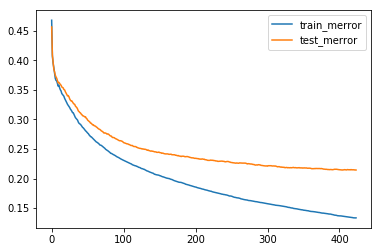

In [589]:
results = model.evals_result()
plt.plot(results['validation_0']['merror'],label='train_merror')
plt.plot(results['validation_1']['merror'],label='test_merror')
plt.legend()

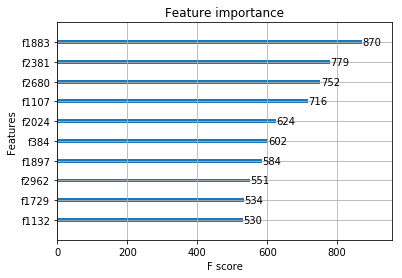

In [590]:
plot_importance(model,max_num_features=10)

In [591]:
for index in [1883,2381,2680,1107,2024,384,1897,2962,1729,1132]:

    print(vect.get_feature_names()[index])

oil
salt
sugar
garlic
pepper
butter
onions
water
milk
ginger


In [641]:
#let's try NN
y_train_encoded = to_categorical(y_train,num_classes=20)
y_test_encoded = to_categorical(y_test,num_classes=20)

In [702]:
K.clear_session()

nn_model = Sequential()

nn_model.add(Dense(128,input_shape=(X_train.shape[1],),kernel_regularizer=regularizers.l2(l=0.02)))
nn_model.add(BatchNormalization())
nn_model.add(Activation('tanh'))
nn_model.add(Dropout(0.2))

nn_model.add(Dense(128,kernel_regularizer=regularizers.l2(l=0.02)))
nn_model.add(BatchNormalization())
nn_model.add(Activation('tanh'))
nn_model.add(Dropout(0.2))

nn_model.add(Dense(128,kernel_regularizer=regularizers.l2(l=0.02)))
nn_model.add(BatchNormalization())
nn_model.add(Activation('tanh'))
nn_model.add(Dropout(0.2))

nn_model.add(Dense(128,kernel_regularizer=regularizers.l2(l=0.02)))
nn_model.add(BatchNormalization())
nn_model.add(Activation('tanh'))
nn_model.add(Dropout(0.2))

nn_model.add(Dense(128,kernel_regularizer=regularizers.l2(l=0.02)))
nn_model.add(BatchNormalization())
nn_model.add(Activation('tanh'))
nn_model.add(Dropout(0.2))

nn_model.add(Dense(128,kernel_regularizer=regularizers.l2(l=0.02)))
nn_model.add(BatchNormalization())
nn_model.add(Activation('tanh'))
nn_model.add(Dropout(0.2))

nn_model.add(Dense(20,activation='softmax'))

nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               390656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
__________

In [699]:
opt = Adam(lr=0.001)
nn_model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['acc'])

In [700]:
hist = nn_model.fit(X_train,y_train_encoded,
             batch_size=128,
             epochs=200,
             validation_split=0.2,
             callbacks=[EarlyStopping(patience=20),
                        ModelCheckpoint("best_model.h5",save_best_only=True)])

Train on 25455 samples, validate on 6364 samples
Epoch 1/200
25455/25455 [==============================] - 196s 8ms/step - loss: 36.3343 - acc: 0.5738 - val_loss: 3.8708 - val_acc: 0.4733
Epoch 2/200
25455/25455 [==============================] - 193s 8ms/step - loss: 3.5696 - acc: 0.5716 - val_loss: 3.8320 - val_acc: 0.5352
Epoch 3/200
25455/25455 [==============================] - 193s 8ms/step - loss: 3.4831 - acc: 0.5780 - val_loss: 3.5577 - val_acc: 0.5666
Epoch 4/200
25455/25455 [==============================] - 195s 8ms/step - loss: 3.4428 - acc: 0.5780 - val_loss: 3.3062 - val_acc: 0.5878
Epoch 5/200
25455/25455 [==============================] - 195s 8ms/step - loss: 3.3254 - acc: 0.5730 - val_loss: 3.3424 - val_acc: 0.5669
Epoch 6/200
25455/25455 [==============================] - 195s 8ms/step - loss: 3.2164 - acc: 0.5887 - val_loss: 3.2387 - val_acc: 0.5669
Epoch 7/200
25455/25455 [==============================] - 192s 8ms/step - loss: 3.1929 - acc: 0.5910 - val_loss: 3.

25455/25455 [==============================] - 197s 8ms/step - loss: 1.8394 - acc: 0.6992 - val_loss: 2.0037 - val_acc: 0.6571
Epoch 60/200
25455/25455 [==============================] - 201s 8ms/step - loss: 1.8335 - acc: 0.7013 - val_loss: 2.2198 - val_acc: 0.6293
Epoch 61/200
25455/25455 [==============================] - 198s 8ms/step - loss: 1.8295 - acc: 0.7067 - val_loss: 2.0732 - val_acc: 0.6186
Epoch 62/200
25455/25455 [==============================] - 204s 8ms/step - loss: 1.8073 - acc: 0.7062 - val_loss: 1.9942 - val_acc: 0.6790
Epoch 63/200
25455/25455 [==============================] - 181s 7ms/step - loss: 1.8131 - acc: 0.7010 - val_loss: 1.9954 - val_acc: 0.6714
Epoch 64/200
25455/25455 [==============================] - 181s 7ms/step - loss: 1.8075 - acc: 0.7025 - val_loss: 1.9533 - val_acc: 0.6689
Epoch 65/200
25455/25455 [==============================] - 181s 7ms/step - loss: 1.8136 - acc: 0.7032 - val_loss: 1.9390 - val_acc: 0.6793
Epoch 66/200
25455/25455 [=======

KeyboardInterrupt: 

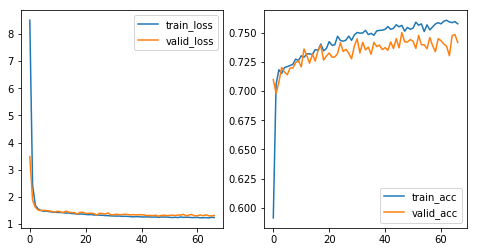

In [701]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(hist.history['loss'],label='train_loss')
plt.plot(hist.history['val_loss'],label='valid_loss')
plt.legend()
plt.subplot(122)
plt.plot(hist.history['acc'],label='train_acc')
plt.plot(hist.history['val_acc'],label='valid_acc')
plt.legend()

In [692]:
y_test_preds = nn_model.predict(X_test)

In [693]:
accuracy_score(y_test,np.argmax(y_test_preds,axis=1)) #accuracy on the test dataset

0.7488372093023256